# Game Prototype of Team Scotland #2
Felix Zaussinger, Martina Buck | 01.12.2020, 15:30

======================================================================================================================

                                            GAME CONFIGURATION

======================================================================================================================

**Magic commands**

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**External imports**

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import configparser
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

**Figure properties**

In [3]:
sns.set_context("poster")
sns.set(rc={'figure.figsize': (8, 5)})
sns.set_style("ticks")

**Directory structure**

In [4]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "plots")
project_dir

'/Users/felix/ETH/code/gecm'

**Append project directory to PYTHONPATH via sys (!)**

Source: https://stackoverflow.com/questions/39299838/how-do-i-import-module-in-jupyter-notebook-directory-into-notebooks-in-lower-dir

In [5]:
if project_dir not in sys.path:
    sys.path.append(project_dir)

#### import our own code from src

In [6]:
from src.gecm.game import MatrixGame
from src.gecm import model, vis, io, game, base, dicts
from src.gecm.dicts import (
        original_lulc_mapping,
        lulc_remapping,
        simplified_lulc_mapping,
        simplified_lulc_mapping_colors
    )

#### Game parameters

In [7]:
# size of playing field in pixels
n_pixels = 80

# complexity of playing field (only granularity = 1 works for now)
granularity = 1

# colormap
simplified_lulc_cm = ListedColormap(
    [simplified_lulc_mapping_colors[x] for x in simplified_lulc_mapping_colors.keys()]
)

# path to raster data file (must be a geotiff)
fpath_map = os.path.join(
    data_processed, "NFI_rasterized_{}_{}.tif".format(n_pixels, n_pixels)
)

#### Configuration file

In [8]:
# init config file parser. methods: config.getboolean, config.getint, ... .
config = configparser.ConfigParser()
fpath_cf = os.path.join(project_dir, 'config.ini')
config.read(fpath_cf)

# Show configuration file sections
io.config_describe(config)


--- default ---
credentials: 'google_api_credentials.json'
scopes: https://www.googleapis.com/auth/spreadsheets.readonly

--- gdrive_spreadsheet_ids ---
spreadsheet_id_farmers: 1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc
spreadsheet_id_foresters: 1ir8WkfKpyEGkamASbd0pf9IDAE74M4Q1fsHYl4r9F34
spreadsheet_id_tourism: 1EA_mCM9Pp_URb_JavM-mMIqixTvZewSkGC2b-wDa1ns
spreadsheet_id_model: 1CVdDndGD1S8ab3D1KlXYcBcnjK8sBPl68Eth0KMgaEQ

--- gdrive_sheet_names ---
sheet_names_farmers: Farmer_1, Farmer_2
sheet_names_foresters: Forester_1, Forester_2
sheet_names_tourism: SSDA
sheet_names_model: model_parameters, model_calculations


#### Google Drive Connection

In [9]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = [config.get(section="default", option="scopes")]

# API credentials
credentials_fpath = os.path.join(project_dir, 'google_api_credentials.json')

#### Conceptual model parameters & calculations

In [10]:
%reload_ext autoreload
model_settings_dict = io.parse_sheets(
        spreadsheet_id=config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_model"), 
        sheets=io.parse_list(config_string=config.get(section="gdrive_sheet_names", option="sheet_names_model")),
        credentials_fpath=credentials_fpath, 
        scopes=SCOPES,
        to_numeric=True
    )

# extract model_parameters as dictionary
model_parameters_dict = model_settings_dict["model_parameters"].loc[:, ["variable", "value"]].set_index("variable").to_dict()["value"]

# TODO: maybe delete
# add to local namespace, quick-fix based on: https://stackoverflow.com/questions/4357851/creating-or-assigning-variables-from-a-dictionary-in-python
# locals().update(model_parameters_dict)

# add model_parameters to config file
config['model_parameters'] = model_parameters_dict

# display contents of config file
# io.config_describe(config)

model_parameters
model_calculations


#### Playing field

In [11]:
%reload_ext autoreload
matrix_game = MatrixGame(
    fpath=fpath_map,
    original_lulc_mapping=original_lulc_mapping,
    simplified_lulc_mapping=simplified_lulc_mapping,
    lulc_remapping=lulc_remapping,
    cmap=simplified_lulc_cm,
    model_param_dict=model_parameters_dict,
    config_file=config
)

# initialise playing field (crucial, else nothing works!)
matrix_game.initialise(granularity=1)

# sanity check on current round
assert matrix_game.current_round == 0

======================================================================================================================

                                            START OF ACTUAL GAME

======================================================================================================================

### Starting Point ("Round 0")

####  Dashboard

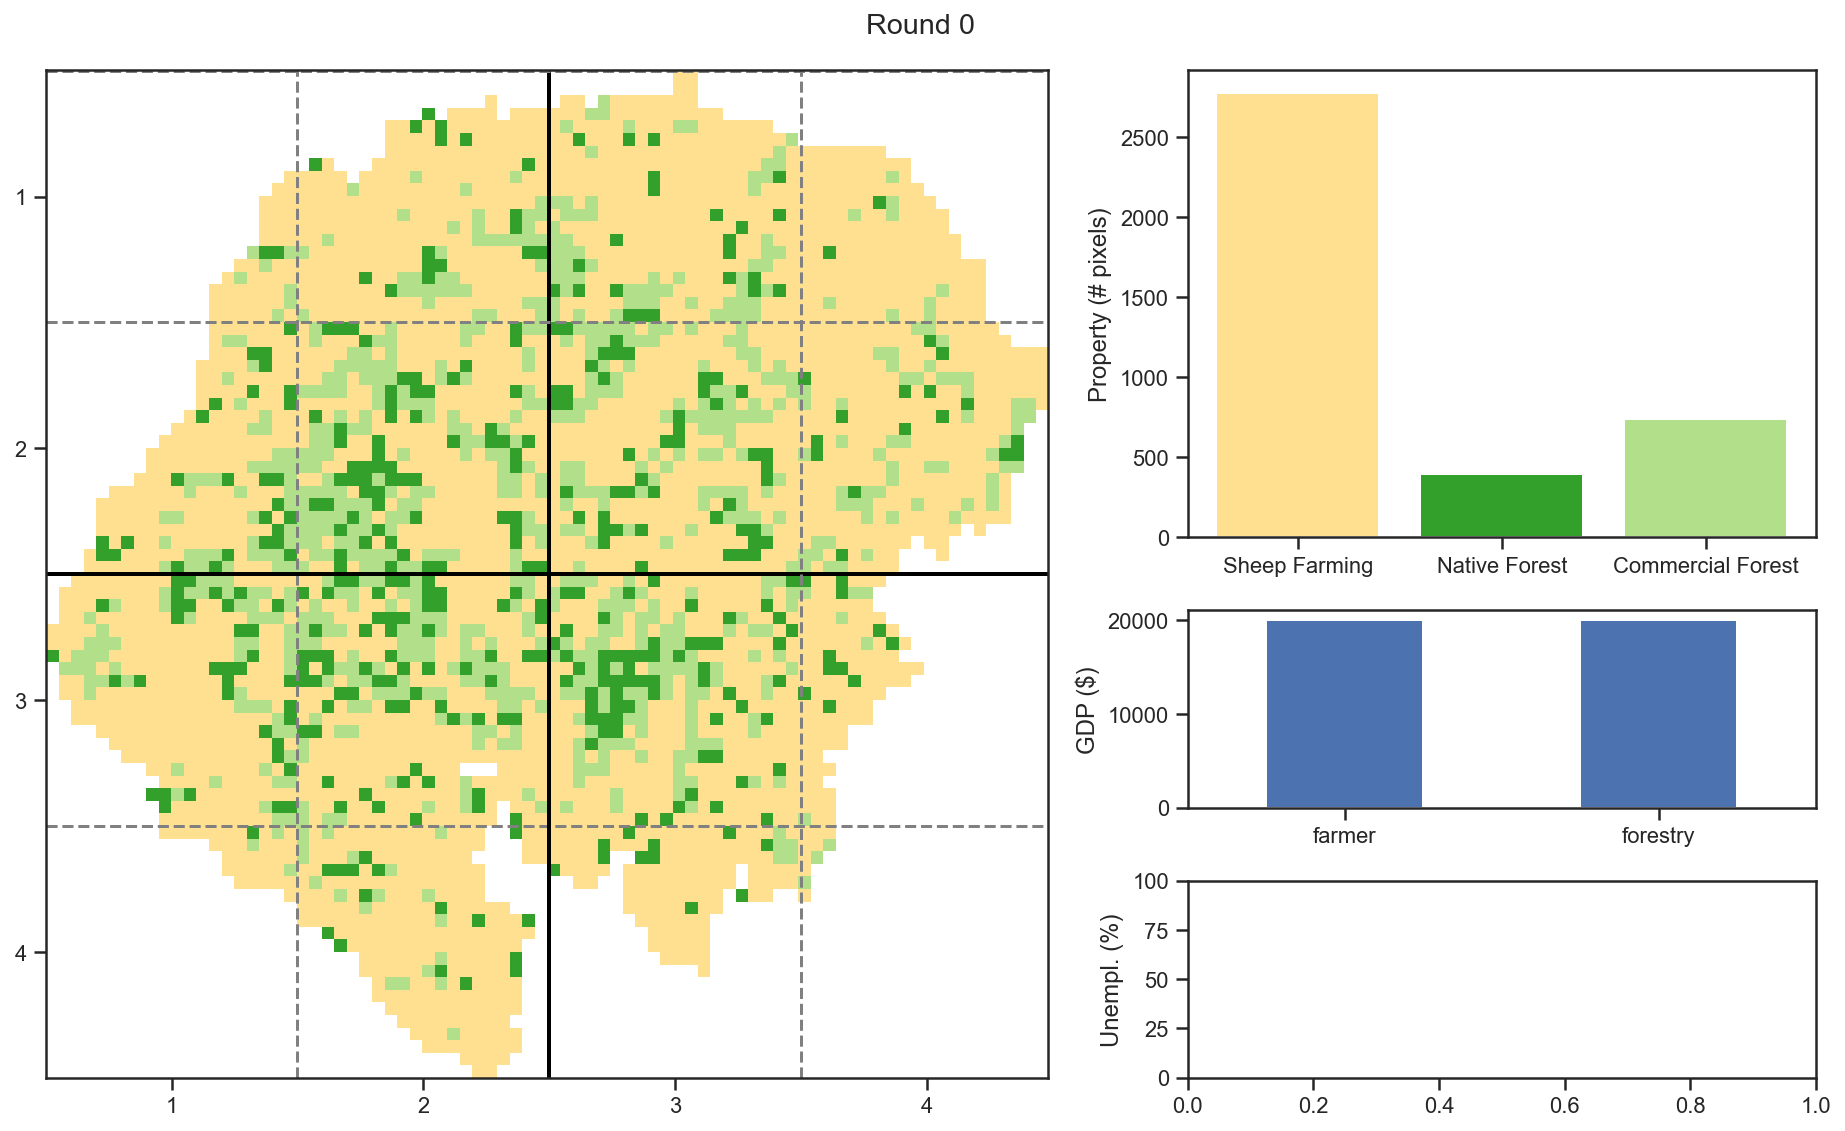

In [12]:
%reload_ext autoreload
matrix_game.show_dashboard(figure_size=(13,8))

### Round 1

#### 1. Downloading management decisions

Farmer_1
Farmer_2
Forester_1
Forester_2
SSDA
CPU times: user 1.93 s, sys: 321 ms, total: 2.25 s
Wall time: 7.18 s


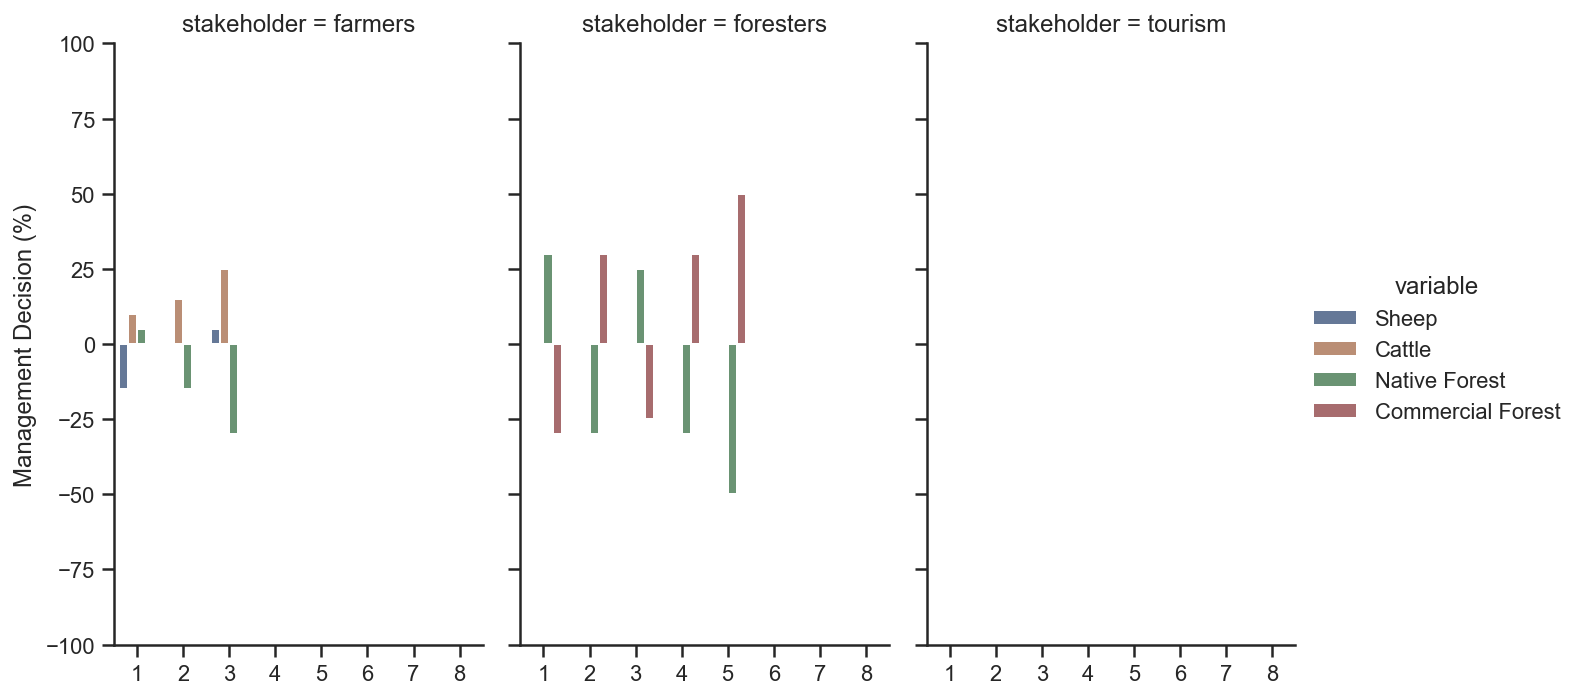

In [13]:
%%time

# download mgmt decisions
df_mgmt_decisions_melted = io.parse_all_mgmt_decisions(config_file=config, credentials_fpath=credentials_fpath)

# visualize
g = sns.catplot(x="round", y="value", hue="variable", col="stakeholder", kind="bar", data=df_mgmt_decisions_melted, saturation=.5, ci=None, aspect=.6)

# https://seaborn.pydata.org/tutorial/relational.html: seaborn supports semantics of hue, size, and style
(g.set_axis_labels("", "Management Decision (%)")
 #.set_xticklabels(["round", "round", "round"])
 #.set_titles("{col_name} {col_var}")
 .set(ylim=(-100, 100)).despine(left=False))

store in class

In [14]:
df_mgmt_decisions_melted

,stakeholder,round,player,Plot,Teamwork,variable,value
0,farmers,1,Farmer_1,NaN,NaN,Sheep,0.0
1,farmers,1,Farmer_2,NaN,NaN,Sheep,-30.0
2,farmers,2,Farmer_1,NaN,NaN,Sheep,0.0
3,farmers,2,Farmer_2,NaN,NaN,Sheep,0.0
4,farmers,3,Farmer_1,NaN,NaN,Sheep,0.0
...,...,...,...,...,...,...,...
155,tourism,4,SSDA,NaN,NaN,Commercial Forest,NaN
156,tourism,5,SSDA,NaN,NaN,Commercial Forest,NaN
157,tourism,6,SSDA,NaN,NaN,Commercial Forest,NaN
158,tourism,7,SSDA,NaN,NaN,Commercial Forest,NaN


#### 2. Calculating Income & updating Bank Accounts

In [15]:
# TODO: MARTINA

#### 3. Updating dashboard (reflect changes in landscape, property allocation, GDP and unemployment)

In [16]:
# TODO: FELIX
data = matrix_game.lulc_matrix_array
print(data.shape)

# access round 0 data
data.reshape((data.shape[0], data.shape[1], 1))[:, :, 0]

(80, 80, 1)


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=255,
  dtype=uint8)

In [17]:
matrix_game.block_definition_matrix_block_lvl

array([[11, 12, 13, 14],
       [21, 22, 23, 24],
       [31, 32, 33, 34],
       [41, 42, 43, 44]], dtype=uint8)

#### 4. Updating round number

In [18]:
%reload_ext autoreload
matrix_game.update_round_number()

## Round 2

#### 0. Sanity check on round number

In [19]:
%reload_ext autoreload
assert matrix_game.get_rounds(True) == 1

#### 1. Downloading management decisions

## Round 3

# Code graveyard

#### Yield calculation

In [20]:
%reload_ext autoreload
# transform dicts & data frame data
# global_yield_remapped = dict(zip(matrix_game.simplified_lulc_mapping.keys(), list(global_yield.values())))
# df_global_yield_remapped = pd.DataFrame(global_yield_remapped, index=["yield"]).transpose()